# Approximation (continued)

In [1]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

In [80]:
testf = lambda x: 1.0/(1.0+x**2)

testfv = np.vectorize(testf)

# restrict the domain to [-1,1]
xlb = -1.0
xub = 1.0

x_grid = np.arange(xlb, xub, step = 0.01) 
fx_grid = testfv(x_grid)


## Regression

Given the Lagrange data $\{(x_i,y_i)\}_{i=1}^m$, we may choose not to interpolate them but to obtain an approximation function using the least squares regression:

$$ \min_{a_1,a_2,...,a_n} \sum_{i=1}^m \left( y_i - \sum_{j=1}^n a_j \phi_j(x_i) \right)^2, $$

where $\{\phi_j(.)\}_{j=1}^n$ is a set of $n$ known functions. (Here $x_i$'s can be multi-dimensional.) A solution to this problem gives us an approximation function of the form

$$ \hat{f}(x) = \sum_{j=1}^n a_j \phi_j(x) $$

and minimizes the sum of squared errors at the data points by definition. 

The OLS is a special case of this. Let $k$ denote the dimensionality of $x$. Then setting $m=k+1$ and 
\begin{eqnarray}
\phi_1(x) &=& 1\\
\phi_j(x) &=& \mbox{ (j-1)-th element of $x$}, \forall j=2,3,...,k
\end{eqnarray}

numpy.polynomial.chebyshev.chebfit() uses a series of Chebyshev polynomials for the problem:

$$ \min_{a_1,a_2,...,a_n} \sum_{i=1}^m w_i^2 \left( y_i - \sum_{j=0}^n a_j T_j(x_i) \right)^2, $$

where $w_i = 1/\sqrt{1-x_i^2}$ is the Chebyshev weighting function at $x_i$.

See <https://docs.scipy.org/doc/numpy/reference/generated/numpy.polynomial.chebyshev.chebfit.html>.

However, we may encounter numerical instability depending on the sample nodes.

## Chebyshev regression

In the _Chebyshev regression_, the data points are Chebyshev nodes, and this assumption simplifies the coefficient-finding problem a lot.

1. Chebyshev nodes are used for $x_1,x_2,...,x_m$:
$$ x_i = - \cos\left(\frac{2i-1}{2m}\pi \right),$$
(these are the roots of $T_n$)
2. Chebyshev polynomials $T_0,T_1,...,T_n$ ($n<m$) are used in place of $\phi's$ above. 

When $m=n+1$, the resulting function

$$ \hat{f}(x) = \sum_{j=0}^n a_j T_j(x) $$ 

goes through all data points $\{(x_i,y_i)\}_{i=1}^m$ and we call it _Chebyshev interpolation_. The goal is to obtain the coefficients $a_0,a_1,...,a_n$.

For each $l=0,...,n$, the first order condition with respect to $a_k$ is given by:

$$ 0 = \sum_{i=1}^m 2 \left( y_i - \sum_{j=1}^n a_j T_j(x_i) \right)(-T_k(x_i)).$$

We can simplify this expression using the following property: for $j,k \le n$, 

\begin{eqnarray}
\sum_{i=1}^m T_j(x_i)T_k(x_i) = \left\{ \begin{array}{cl}
                                            0 & \mbox{ if j $\neq$ k}\\
                                            m & \mbox{ if j $=$ k $=$0}\\
                                            \frac{m}{2} & \mbox{ if j $=$ k $\neq$ 0}
                                            \end{array}\right.
\end{eqnarray}

Hence,

$$ \sum_{i=1}^m y_iT_k(x_i) = \sum_{j=1}^n a_j (\sum_{i=1}^m T_j(x_i)T_k(x_i))=a_k (\sum_{i=1}^m T_k(x_i)^2).$$

i.e.

\begin{eqnarray}
a_k = \frac{\sum_{i=1}^m y_iT_k(x_i)}{\sum_{i=1}^m T_k(x_i)^2} = \left\{ \begin{array}{cl}
                                            \frac{1}{m}\sum_{i=1}^m y_i & \mbox{ if k=0}\\
                                            \frac{2}{m}\sum_{i=1}^m y_iT_k(x_i) & \mbox{ if k $\neq$ 0}
                                            \end{array}\right.
\end{eqnarray}

### Chebyshev regression algorithm

The following is an algorithm for a function $f$ on $[-1,1]$. 

1. Choose $n$ and $m$ so that $n<m$. 

2. Compute the Chebyshev nodes $x_1,x_2,...,x_m$.

3. Evaluate the function $f$ on the Chebyshev nodes.

4. Using the above formula, obtain the coefficients $a_0,a_1,...,a_n$ on the Chebyshev polynomials $T_0, T_1,...,T_n$.

5. When evaluating the approximating function $\sum_{i=0}^n a_i T_i(x)$ at $x \in [-1,1]$, use the recursion (see the week 1 assignment).



Numpy has Chebyshev module <https://docs.scipy.org/doc/numpy/reference/routines.polynomials.chebyshev.html>.

For example, evaluation of $\sum_{i=0}^n a_i T_i(x)$ can be done by passing $x$ and $(a_0,a_1,...,a_n)$ to numpy.polynomial.chebyshev.chebval(). <https://docs.scipy.org/doc/numpy/reference/generated/numpy.polynomial.chebyshev.chebval.html#numpy.polynomial.chebyshev.chebval>

In [93]:

# calculate data
m = 11

x_data = np.zeros(m)
for i in range(m):
    x_data[i] = xlb + (xub-xlb)/2*(-np.cos((2*(i+1)-1)*np.pi/(2*m))+1.0)
    
fx_data = testfv(x_data)    


In [99]:
# Choose n <= m-1
n = 5

coef = np.zeros(n+1)

Tmat = np.zeros((n+1,m))
Tmat[0,:] = 1.0
Tmat[1,:] = x_data[:]

for k in range(2,n+1):
    Tmat[k,:] = 2*np.reshape(x_data,(1,m))*Tmat[k-1,:]-Tmat[k-2,:]

    
for k in range(n+1):
    coef[k] = np.array(fx_data)@Tmat[k,:]
    
coef[0] /= m
coef[1:] /= (m/2)

fx_cheb = np.polynomial.chebyshev.chebval(x_grid,coef)


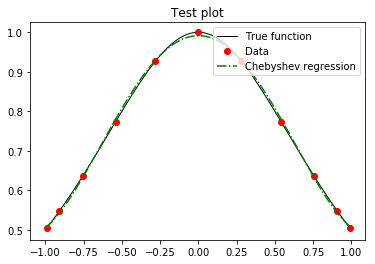

In [100]:
fig, ax = plt.subplots()

line1, = ax.plot(x_grid, fx_grid, 'k-', linewidth=1, label='True function')
line2, = ax.plot(x_data, fx_data, 'ro', linewidth=1, label='Data')
line3, = ax.plot(x_grid, fx_cheb, 'g-.', label='Chebyshev regression')
ax.legend(loc='upper right')
ax.set_title('Test plot')

plt.show()

## Chebyshev least squares approximation

Consider a space of functions on $[-1,1]$ that are square-integrable with respect to a weighting function $w$ ($w(x)\ge0$ for all $x$ and $\int_{-1}^{1} w(x)dx<\infty$), i.e.

$$  \int_{-1}^{1} f(x)^2w(x)dx<\infty. $$

For any $f$ and $g$ in this space we can define the inner product:

$$ <f,g> := \int_{-1}^{1} f(x)g(x)w(x)dx $$

We say two functions are orthogonal when their inner product is zero. 

For any function $f$ in this space, the inner product norm is defined as

$$ ||f||_2 = \sqrt{<f,f>} = \left(\int_{-1}^{1} f(x)^2w(x)dx\right)^\frac{1}{2}.$$

This norm is also called the $L^2$-norm. You don't need to worry too much about this. Basically what we use is that this norm defines a particular way to evaluate how close two functions are:

$$ || f-g ||_2 =\left(\int_{-1}^{1} (f(x)-g(x))^2w(x)dx\right)^\frac{1}{2}. $$

$L^2$ approximation problem given $f$ is to find a function $g$ from a particular subspace (e.g. a set of polynomials of order $\le n$) to minimize $|| f-g ||_2$ or equivalently $|| f-g ||_2^2$.



With $w(x) = \frac{1}{\sqrt{1-x^2}}$, Chebyshev polynomials with different orders are _orthogonal_:

\begin{eqnarray}
 <T_i,T_j> = \left\{ \begin{array}{cl}
                                            0 & \mbox{ if  $i \neq j$}\\
                                            \pi & \mbox{ if $i = j=0$}\\
                                            \frac{\pi}{2} & \mbox{ if $i=j\neq 0$}
                                            \end{array}\right.
\end{eqnarray}

It is easy to check any polynomial $p$ of order $n$ can be written as

$$ p(x) = \sum_{i=0}^n a_i T_i(x). $$

Hence, solving the $L^2$ approximation problem using a $n$-th order polynomial is equivalent to solving:

$$ \min_{a_0,a_1,...,a_n} \int_{-1}^{1} (f(x)-\sum_{i=0}^n a_i T_i(x))^2 w(x)dx.$$

The first order condition for $a_k$ is

$$  0 = \int_{-1}^{1} (f(x)-\sum_{i=0}^n a_i T_i(x))(-T_k(x)) w(x)dx = <f-\sum_{i=0}^n a_i T_i,-T_k> = -<f,T_k>+\sum_{i=0}^n a_i<T_i,T_k>= -<f,T_k>+a_i<T_k,T_k>.$$

Hence,

$$a_k = \frac{<f,T_k>}{<T_k,T_k>},$$

which is analogous to what we found for the Chebyshev regression problem.


Although the coefficients are expressed in a rather simple form, their computation requires integrations. We will study how we numarically integrate functions in next week.



# Multidimensional interpolation/approximation

Multidimensional interpolation and approximation are more difficult than the one dimensional methods we studied and  some nice properties of the methods in one dimensional case may be lost.

Consider interpolating the following data linearly:

\begin{eqnarray}
(x_1, y_1 ) &=& ((0,0),0)\\
(x_2, y_2 ) &=& ((0,1),1)\\
(x_3, y_3 ) &=& ((1,0),1)\\
(x_4, y_4 ) &=& ((1,1),0)
\end{eqnarray}

On the rectangular $[0,1] \times [0,1]$, is your interpolant concave or convex? 

The Lagrange interpolation problem may not have a solution. Consider a two dimensional Lagrange interpolation with 
\begin{eqnarray}
x_1 &=& (1,0)\\
x_2 &=& (-1,0)\\
x_3 &=& (0,-1)\\
x_4 &=& (0,1)
\end{eqnarray}
and some $y_1,...,y_4$, using 

$$P(x) = a + b x(1) + c x(2) + dx(1)x(2).$$

The problem of the above Lagrange data is that $x(1)x(2)$ is always zero, and we only have three degrees of freedom ($a$, $b$, and $c$) to interpolate four data points, which is in general impossible. [This example is taken from Judd.] 



### Bilinear interpolation

Bilinear interpolation is, as its name suggests, a generalization of the linear interpolation method in one-dimensional case. 

Recall that, in the one-dimensional situation, the linear interpolant of two data points, $(x_1,f(x_1))$ and $(x_2,f(x_2)$ with $x_2>x_1$, is 
$$ \hat{f}(x) = \frac{x_2-x}{x_2-x_1}f(x_1) + \frac{x-x_1}{x_2-x_1}f(x_2). $$

In words, we assign the weight $\frac{x-x_1}{x_2-x_1}$ to the function value at $x_2$ and $\frac{x_2-x}{x_2-x_1}$ to the function value at $x_1$. 

Bilinear interpolation generalizes this to the two-dimensional situation. 

Imagine that we are interpolating four data points, $( (x_1,y_1),f(x_1,y_1))$, $( (x_2,y_1),f(x_2,y_1))$, $( (x_1,y_2),f(x_1,y_2))$, $( (x_2,y_2),f(x_2,y_2))$, over the rectangle $[x_1,x_2] \times [y_1, y_2]$. Bilinear interpolant is given by:

\begin{eqnarray}
\hat{f}(x,y) &=& \frac{(x_2-x)(y_2-y)}{(x_2-x_1)(y_2-y_1)}f(x_1,y_1) + \frac{(x_2-x)(y-y_1)}{(x_2-x_1)(y_2-y_1)}f(x_1,y_2)\\
&& + \frac{(x-x_1)(y_2-y)}{(x_2-x_1)(y_2-y_1)}f(x_2,y_1) + \frac{(x-x_1)(y-y_1)}{(x_2-x_1)(y_2-y_1)}f(x_2,y_2)
\end{eqnarray}

Hence, the bilinear interpolant is not linear on the interior of the rectangle but is quadratic. On the edge of the rectangle, however, it becomes linear. E.g. when $y = y_1$, 

\begin{eqnarray}
\hat{f}(x,y_1) &=& \frac{(x_2-x)}{(x_2-x_1)}f(x_1,y_1) + \frac{(x-x_1)}{(x_2-x_1)}f(x_2,y_1),
\end{eqnarray}

which is linear. This property is important, because it implies that the interpolants on rectangles that are next to each other connect on the edge.

scipy.interpolate.interp2d() implements this, with kind='linear' (default).


### Tensor product

Some one-dimensional methods can be extendable to multi-dimensional cases using the tensor product. 

Consider Chebyshev approximation in $\mathbb{R}^2$. Let

$$\psi_{i,j}(x,y) := T_i(x)T_j(y)$$

for $i,j = 0,...,n$. (We do not have to use the same order for two dimensions. This is to simplify notations.)

With the weighting function $W(x,y):=w(x)w(y)$, it is easy to show that $\{\psi_{i,j}\}_{(i,j)}$ is a set of orthogonal polynomials, because


$$ <\psi_{i,j},\psi_{i',j'}> = \int_x\int_y T_i(x)T_j(y)T_{i'}(x)T_{j'}(y)W(x,y)dxdy = \int_x T_i(x)T_{i'}(x)w(x)dx \times \int_yT_j(y)T_{j'}(y)w(y)dy.$$

For the $L^2$ approximation problem, the approximation function will be 

$$ \hat{f}(x,y) = \sum_{k,l} \frac{<f,\psi_{k,l}>}{<\psi_{i,j},\psi_{k,l}>} \psi_{k,l}(x,y). $$ 

For the regression problem, the approximation function will be

$$ \hat{f}(x,y) = \sum_{k,l} \frac{\sum_{i=1}^m \sum_{j=1}^m f(x_i,y_j) T_k(x_i)T_l(y_i)}{\left(\sum_{i=1}^m T_k(x_i)^2\right)\left(\sum_{i=1}^m T_l(y_i)^2\right)}\psi_{k,l}(x,y). $$

Both $\{x_i\}$ and $\{y_i\}$ are Chebyshev nodes. (Again, we can apply the previous formulas to the denominator of each coefficient.)

One problem is the size. If we use $n$ polynomials per dimension, there are $n^2$ product in the two dimension case, and the size grows exponentially.

**Quiz**

1. Use Chebyshev interporation nodes, and compare the performances of the Lagrange interporation and the Chebyshev interporation.
2. Explain how we can extend the Chebyshev regression algorithm to the case where $f:[a,b]\rightarrow \mathbb{R}$. You don't need to modify the code.
3. Instead of the Chebyshev nodes, let us use an equally-spaced grid of 11 points between -1 and 1 as $\{x_i\}_{i=1}^{11}$. Using numpy.polynomial.chebyshev.chebfit(), obtain an approximation polynomial function of order 5. Note that numpy.polynomial.chebyshev.chebfit() does not return the approximate function. 
4. In the two dimensional Chebyshev regression, figure out how the denominator of the coefficient on $\psi_{k,l}$, 
$$ \left(\sum_{i=1}^m T_k(x_i)^2\right)\left(\sum_{i=1}^m T_l(y_i)^2\right), $$
simplifies depending on $k$ and $l$.